In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
from osgeo import gdal

In [12]:
where = Path(r"Datasets_Hackathon")
datasets = [x for x in where.iterdir() if x.is_dir()]

In [13]:
datasets

[PosixPath('Datasets_Hackathon/Gridded_Population_Density_Data'),
 PosixPath('Datasets_Hackathon/Admin_layers'),
 PosixPath('Datasets_Hackathon/Streamwater_Line_Road_Network'),
 PosixPath('Datasets_Hackathon/Modis_Land_Cover_Data'),
 PosixPath('Datasets_Hackathon/MODIS_Gross_Primary_Production_GPP'),
 PosixPath('Datasets_Hackathon/Climate_Precipitation_Data')]

In [14]:
def split_full_extension(path: Path) -> tuple:
    path = path.name
    if '.' in path:
        ex = path.split('.', 1)[1]
    else:
        ex = ''

    return path.split('.', 1)[0], ex

In [15]:
extensions = {}
for dir in datasets:
    if dir.name not in extensions:
            extensions[dir.name] = []
    for p in list(datasets[0].glob("*")):
        name, ex = split_full_extension(p)
        extensions[dir.name].append(ex)

extensions = {k: set(v) for k, v in extensions.items()}

In [16]:
print(extensions)

{'Gridded_Population_Density_Data': {'tif', 'tfw', 'tif.xml', 'png', 'tif.aux.xml', 'tif.ovr'}, 'Admin_layers': {'tif', 'tfw', 'tif.xml', 'png', 'tif.aux.xml', 'tif.ovr'}, 'Streamwater_Line_Road_Network': {'tif', 'tfw', 'tif.xml', 'png', 'tif.aux.xml', 'tif.ovr'}, 'Modis_Land_Cover_Data': {'tif', 'tfw', 'tif.xml', 'png', 'tif.aux.xml', 'tif.ovr'}, 'MODIS_Gross_Primary_Production_GPP': {'tif', 'tfw', 'tif.xml', 'png', 'tif.aux.xml', 'tif.ovr'}, 'Climate_Precipitation_Data': {'tif', 'tfw', 'tif.xml', 'png', 'tif.aux.xml', 'tif.ovr'}}


In [17]:
test_file = list(datasets[0].glob("*.tif"))[0]

In [18]:
dataset = gdal.Open(test_file, gdal.GA_ReadOnly)

In [19]:
print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                            dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
geotransform = dataset.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

Driver: GTiff/GeoTIFF
Size is 1468 x 1509 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-17.067916600296257, 27.299583421127153)
Pixel Size = (0.0083333333, -0.0083333333)


In [20]:
band = dataset.GetRasterBand(1)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

min = band.GetMinimum()
max = band.GetMaximum()
if not min or not max:
    (min,max) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))

if band.GetOverviewCount() > 0:
    print("Band has {} overviews".format(band.GetOverviewCount()))

if band.GetRasterColorTable():
    print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))

Band Type=Float32
Min=0.000, Max=51747.500
Band has 1 overviews


In [21]:
from osgeo import ogr

# Paths to your input shapefile and output GeoTIFF
input_shapefile = "input.shp"
output_tif = "output.tif"

# Open the shapefile
data_source = ogr.Open(input_shapefile)
layer = data_source.GetLayer()

# Create a GeoTIFF raster with desired dimensions and georeferencing
pixel_size = 30  # Resolution (e.g., 30m per pixel)
x_min, x_max, y_min, y_max = layer.GetExtent()
x_res = int((x_max - x_min) / pixel_size)
y_res = int((y_max - y_min) / pixel_size)

driver = gdal.GetDriverByName('GTiff')
raster = driver.Create(output_tif, x_res, y_res, 1, gdal.GDT_Byte)  # 1 Band, Byte data type
raster.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))  # Geotransform
band = raster.GetRasterBand(1)
band.SetNoDataValue(0)

# Rasterize: Burn a value (e.g., 255) into the raster where vector features exist
gdal.RasterizeLayer(raster, [1], layer, burn_values=[255])
raster = None  # Close and save the GeoTIFF


AttributeError: 'NoneType' object has no attribute 'GetLayer'

In [22]:
import os
import sys
from osgeo import gdal, osr

In [ ]:
def gather_raster_files(root_dir):
    """
    Recursively collects primary raster files.
    We consider files ending in .tif, .tiff, or .png. Any auxiliary files 
    (like .tfw, .ovr, .aux.xml, .xml) are assumed to accompany these primary files.
    """
    valid_extensions = ['.tif', '.tiff', '.png']
    full_list = []
    for dirpath, _, filenames in os.walk(root_dir):
        """
        if "Population_Density" in dirpath:
            continue
        """

        for f in filenames:
            """
            if f == "Population_mrt_pd_1km_2005_Image.png":
                print("HERE")
                continue"
            """
            ext = os.path.splitext(f)[1].lower()
            if ext in valid_extensions:
                full_list.append(os.path.join(dirpath, f))
    return full_list

In [110]:
def get_valid_data_extent(filepath):
    """
    Open a raster, read its first band, and compute the georeferenced bounding box of
    valid (non-nodata) pixels.
    
    Returns (xmin, ymin, xmax, ymax) in the file's coordinate system.
    """
    ds = gdal.Open(filepath)
    if ds is None:
        print(f"Failed to open {filepath}")
        return None
    band = ds.GetRasterBand(1)
    nodata = band.GetNoDataValue()
    arr = band.ReadAsArray()
    
    # If no nodata value is defined, assume every pixel is valid.
    if nodata is None:
        mask = np.full(arr.shape, True, dtype=bool)
    else:
        mask = (arr != nodata)
    
    # If there are no valid pixels, return None.
    if not np.any(mask):
        ds = None
        return None
    
    # Find row and column indices of valid pixels.
    valid_rows, valid_cols = np.where(mask)
    row_min = int(valid_rows.min())
    row_max = int(valid_rows.max())
    col_min = int(valid_cols.min())
    col_max = int(valid_cols.max())
    
    # Get the geotransform to map pixel coordinates onto geospatial coordinates.
    gt = ds.GetGeoTransform()
    ds = None

    # Compute coordinates:
    # For pixel (col, row), coordinate = (gt[0] + col*gt[1] + row*gt[2], gt[3] + col*gt[4] + row*gt[5])
    # Compute corners of the valid window:
    ul_x = gt[0] + col_min * gt[1] + row_min * gt[2]
    ul_y = gt[3] + col_min * gt[4] + row_min * gt[5]
    lr_x = gt[0] + col_max * gt[1] + row_max * gt[2]
    lr_y = gt[3] + col_max * gt[4] + row_max * gt[5]

    xmin = min(ul_x, lr_x)
    xmax = max(ul_x, lr_x)
    ymin = min(ul_y, lr_y)
    ymax = max(ul_y, lr_y)
    
    return (xmin, ymin, xmax, ymax)

In [85]:
def get_raster_info(filepath, target_srs="EPSG:4326"):
    """
    Opens the raster using GDAL (GDAL will automatically make use of any auxiliary files
    that sit alongside the primary file such as .tfw or .aux.xml). Then it reprojects the
    corner coordinates into the target SRS, computes the extent, and estimates the pixel size.
    
    Returns a dictionary with:
      - filepath: the file path
      - xmin, xmax, ymin, ymax: the extent in target SRS
      - pixel_size: an approximate pixel size in the target SRS
    """
    ds = gdal.Open(filepath)
    if ds is None:
        print(f"Failed to open {filepath}")
        return None

    gt = ds.GetGeoTransform()
    proj = ds.GetProjection()

    # Create source spatial reference object.
    srs_source = osr.SpatialReference()
    if proj and proj.strip() != "":
        srs_source.ImportFromWkt(proj)
    else:
        # if no projection info is present, assume the target SRS.
        srs_source.ImportFromEPSG(int(target_srs.split(':')[1]))

    # Create target spatial reference.
    srs_target = osr.SpatialReference()
    srs_target.ImportFromEPSG(int(target_srs.split(':')[1]))

    # Prepare a coordinate transformation.
    transform = osr.CoordinateTransformation(srs_source, srs_target)

    width = ds.RasterXSize
    height = ds.RasterYSize

    # Compute corner coordinates in source SRS.
    ul = (gt[0], gt[3])  # upper left
    ur = (gt[0] + width * gt[1], gt[3])
    ll = (gt[0], gt[3] + height * gt[5])
    lr = (gt[0] + width * gt[1], gt[3] + height * gt[5])

    # Transform corners to target SRS.
    corners = [transform.TransformPoint(pt[0], pt[1]) for pt in [ul, ur, ll, lr]]
    xs = np.array([p[0] for p in corners], dtype=np.float64)
    ys = np.array([p[1] for p in corners], dtype=np.float64)
    xmin = xs.min()
    xmax = xs.max()
    ymin = ys.min()
    ymax = ys.max()

    # Calculate an approximate pixel size in the target SRS
    # (by transforming a one-pixel step along the x-axis).
    p1 = transform.TransformPoint(gt[0], gt[3])
    p2 = transform.TransformPoint(gt[0] + gt[1], gt[3])
    pix_size = abs(p2[0] - p1[0])
    if pix_size == 0:
        print(filepath, pix_size)

    ds = None
    return {
        "filepath": filepath,
        "xmin": xmin,
        "xmax": xmax,
        "ymin": ymin,
        "ymax": ymax,
        "pixel_size": pix_size
    }

In [111]:
def compute_global_extent_and_resolution(file_list, target_srs="EPSG:4326"):
    """
    Takes a list of file info dictionaries and computes:
      - The union extent in target SRS (xmin, ymin, xmax, ymax)
      - The smallest pixel size (i.e. the highest resolution) among all rasters.
    """

    srs_target = osr.SpatialReference()
    srs_target.ImportFromEPSG(int(target_srs.split(":")[1]))

    global_xmin = float('inf')
    global_ymin = float('inf')
    global_xmax = -float('inf')
    global_ymax = -float('inf')
    min_pixel = float('inf')

    for filepath in file_list:
        valid_extent = get_valid_data_extent(filepath)
        if valid_extent is None:
            continue
        # Convert the valid extent from the source SRS to the target SRS.
        ds = gdal.Open(filepath)
        proj = ds.GetProjection()
        srs_source = osr.SpatialReference()
        if proj and proj.strip():
            srs_source.ImportFromWkt(proj)
        else:
            srs_source.ImportFromEPSG(int(target_srs.split(':')[1]))
        transform = osr.CoordinateTransformation(srs_source, srs_target)
        xmin, ymin, xmax, ymax = valid_extent
        
        # Transform the four corners.
        corners = [
            transform.TransformPoint(xmin, ymin),
            transform.TransformPoint(xmin, ymax),
            transform.TransformPoint(xmax, ymin),
            transform.TransformPoint(xmax, ymax)
        ]
        xs = [pt[0] for pt in corners]
        ys = [pt[1] for pt in corners]
        
        global_xmin = min(global_xmin, min(xs))
        global_ymin = min(global_ymin, min(ys))
        global_xmax = max(global_xmax, max(xs))
        global_ymax = max(global_ymax, max(ys))
        ds = None

    return (global_xmin, global_ymin, global_xmax, global_ymax)
    
    """
    for info in file_infos:
        global_xmin = np.array([global_xmin, info['xmin']], dtype=np.float64).min()
        global_ymin = np.array([global_ymin, info['ymin']], dtype=np.float64).min()
        global_xmax = np.array([global_xmax, info['xmax']], dtype=np.float64).max()
        global_ymax = np.array([global_ymax, info['ymax']], dtype=np.float64).max()
        if info['pixel_size'] < min_pixel and info['pixel_size'] > 0:
            min_pixel = info['pixel_size']"
    """

    
    return (global_xmin, global_ymin, global_xmax, global_ymax, min_pixel)

In [87]:
def process_raster(file_info, global_bounds, target_resolution, target_srs, output_dir, input_root):
    """
    Reprojects/resamples a single raster file to the common grid defined by:
      - global_bounds: (xmin, ymin, xmax, ymax)
      - target_resolution: the smallest pixel size collected
      - target_srs: the common coordinate system (default "EPSG:4326")
      
    To decide on the resampling algorithm:
      - If the source pixel is larger (i.e. coarser) than target_resolution,
        use "average" so that the coarse value is consistently applied over the multiple output pixels.
      - Otherwise, use a bilinear interpolation.
    
    The output file is written (as a GeoTIFF) preserving the relative directory structure.
    """
    (global_xmin, global_ymin, global_xmax, global_ymax) = global_bounds
    source_pixel = file_info['pixel_size']
    
    # Compare the native pixel size with the chosen target.
    if source_pixel > target_resolution * 1.01:  # allow a little tolerance
        resample_alg = "average"
    else:
        resample_alg = "bilinear"
    
    input_filepath = file_info['filepath']
    rel_path = os.path.relpath(input_filepath, start=input_root)
    base, _ = os.path.splitext(rel_path)
    output_filepath = os.path.join(output_dir, base + "_norm.tif")
    os.makedirs(os.path.dirname(output_filepath), exist_ok=True)
    
    warp_options = gdal.WarpOptions(
        format="GTiff",
        dstSRS=target_srs,
        outputBounds=(global_xmin, global_ymin, global_xmax, global_ymax),
        xRes=target_resolution,
        yRes=target_resolution,
        resampleAlg=resample_alg,
        dstNodata=0  # you could choose another nodata value if needed
    )
    
    print(f"Processing:\n  {input_filepath}\n--> {output_filepath}")
    print(f"Resampling method: {resample_alg}")
    
    result = gdal.Warp(output_filepath, input_filepath, options=warp_options)
    if result is None:
        print(f"Error processing {input_filepath}")
    else:
        result = None
        print(f"Saved normalized raster to {output_filepath}\n")

In [88]:
input_root = r"Datasets_Hackathon"
output_root = r"Transformed"
raster_files = gather_raster_files(input_root)

target_srs = "EPSG:4326"

In [89]:
file_infos = []
with open("test.txt", "w") as f:
    for filepath in raster_files:
        info = get_raster_info(filepath, target_srs)
        print("File:", os.path.basename(filepath), "INFO:", info)
        f.write(str(" ".join(["File:", os.path.basename(filepath), "INFO:", str(info)])) + "\n")
        if info:
            file_infos.append(info)

compute_global_extent_and_resolution(file_infos)

Datasets_Hackathon/Modis_Land_Cover_Data/2011LCT.tif 0.0
File: 2011LCT.tif INFO: {'filepath': 'Datasets_Hackathon/Modis_Land_Cover_Data/2011LCT.tif', 'xmin': np.float64(15.108333331976493), 'xmax': np.float64(18.312499998353495), 'ymin': np.float64(-13.061472785182145), 'ymax': np.float64(-10.405502310243788), 'pixel_size': 0.0}
Datasets_Hackathon/Modis_Land_Cover_Data/2010LCT.tif 0.0
File: 2010LCT.tif INFO: {'filepath': 'Datasets_Hackathon/Modis_Land_Cover_Data/2010LCT.tif', 'xmin': np.float64(15.108333331976493), 'xmax': np.float64(18.312499998353495), 'ymin': np.float64(-13.061472785182145), 'ymax': np.float64(-10.405502310243788), 'pixel_size': 0.0}
Datasets_Hackathon/Modis_Land_Cover_Data/2022LCT.tif 0.0
File: 2022LCT.tif INFO: {'filepath': 'Datasets_Hackathon/Modis_Land_Cover_Data/2022LCT.tif', 'xmin': np.float64(15.108333331976493), 'xmax': np.float64(18.312499998353495), 'ymin': np.float64(-13.061472785182145), 'ymax': np.float64(-10.405502310243788), 'pixel_size': 0.0}
Dataset

(np.float64(-12.849997509270906),
 np.float64(-13.061472785182145),
 np.float64(18.312499998353495),
 np.float64(18.349999528378248),
 0.05000000074505806)

In [90]:
global_xmin, global_ymin, global_xmax, global_ymax, min_pixel = compute_global_extent_and_resolution(file_infos)
global_bounds = (global_xmin, global_ymin, global_xmax, global_ymax)
target_resolution = min_pixel

In [99]:
global_bounds

(np.float64(-12.849997509270906),
 np.float64(-13.061472785182145),
 np.float64(18.312499998353495),
 np.float64(18.349999528378248))

In [91]:
target_resolution

0.05000000074505806

In [92]:
global_xmax

np.float64(18.312499998353495)

In [93]:
for info in file_infos:
    process_raster(info, global_bounds, target_resolution, target_srs, output_root, input_root)

Processing:
  Datasets_Hackathon/Modis_Land_Cover_Data/2011LCT.tif
--> Transformed/Modis_Land_Cover_Data/2011LCT_norm.tif
Resampling method: bilinear
Saved normalized raster to Transformed/Modis_Land_Cover_Data/2011LCT_norm.tif

Processing:
  Datasets_Hackathon/Modis_Land_Cover_Data/2010LCT.tif
--> Transformed/Modis_Land_Cover_Data/2010LCT_norm.tif
Resampling method: bilinear
Saved normalized raster to Transformed/Modis_Land_Cover_Data/2010LCT_norm.tif

Processing:
  Datasets_Hackathon/Modis_Land_Cover_Data/2022LCT.tif
--> Transformed/Modis_Land_Cover_Data/2022LCT_norm.tif
Resampling method: bilinear
Saved normalized raster to Transformed/Modis_Land_Cover_Data/2022LCT_norm.tif

Processing:
  Datasets_Hackathon/Modis_Land_Cover_Data/2017LCT.tif
--> Transformed/Modis_Land_Cover_Data/2017LCT_norm.tif
Resampling method: bilinear
Saved normalized raster to Transformed/Modis_Land_Cover_Data/2017LCT_norm.tif

Processing:
  Datasets_Hackathon/Modis_Land_Cover_Data/2016LCT.tif
--> Transformed/M

In [29]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from osgeo import gdal
import numpy as np

MovieWriter imagemagick unavailable; using Pillow instead.


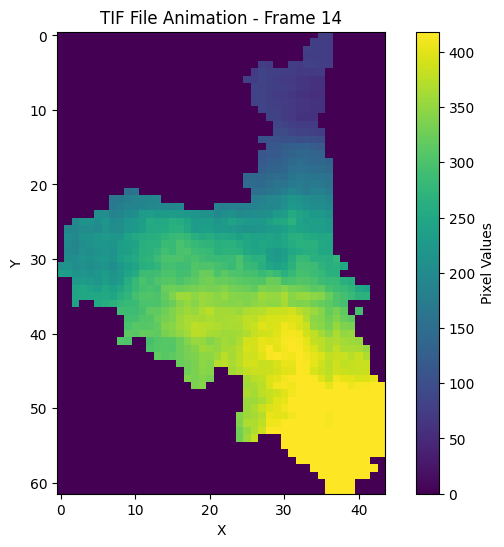

In [33]:
files = [os.path.join("Transformed", p) for p in os.listdir("Transformed")]

def read_tif(file):
    ds = gdal.Open(file)
    band = ds.GetRasterBand(1)
    data = band.ReadAsArray()
    ds = None
    return data

# Read the first file to get the dimensions
sample_data = read_tif(files[0])

# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(sample_data, cmap='viridis', animated=True)
plt.colorbar(img, ax=ax, label="Pixel Values")
ax.set_title("TIF File Animation")
ax.set_xlabel("X")
ax.set_ylabel("Y")

def update(frame):
    data = read_tif(files[frame])
    img.set_array(data)
    ax.set_title(f"TIF File Animation - Frame {frame + 1}")
    return img,

ani = FuncAnimation(
    fig, update, frames=len(files), interval=1000, blit=True
)

ani.save("tif_animation.gif", writer="imagemagick")



In [52]:
file = r"Transformed/MODIS_Gross_Primary_Production_GPP/2010_GP_norm.tif"
output_file = r"test_projected.tif"

ds = gdal.Warp(output_file, file, dstSRS="EPSG:4326")
ds = None

ds = gdal.Open(output_file)

band = ds.GetRasterBand(1)
data = band.ReadAsArray()


def get_native_pixel_size(filepath):
    """
    Opens the file and extracts the native pixel size (absolute value of gt[1]).
    Assumes square pixels.
    """
    ds = gdal.Open(filepath)
    if ds is None:
        print(f"Could not open file: {filepath}")
        return None
    gt = ds.GetGeoTransform()
    ds = None
    return abs(gt[1]), abs(gt[5]), gt[0]

def get_effective_pixel_size(filepath):
    ds = gdal.Open(filepath)
    if ds is None:
        print(f"Could not open file: {filepath}")
        return None
    gt = ds.GetGeoTransform()
    ds = None
    # Compute effective pixel dimensions
    pixel_width = (gt[1]**2 + gt[2]**2)**0.5
    pixel_height = (gt[4]**2 + gt[5]**2)**0.5
    # If the pixels are roughly square, return an average.
    return (pixel_width + pixel_height) / 2


print(get_native_pixel_size(file))
print(get_effective_pixel_size(file))

gt = ds.GetGeoTransform()
print(gt[1])

ds = None

(0.0083333333, 0.0083333333, 15.112499998642782)
0.0083333333
0.0083333333


In [61]:
file = r"newly_shaped.tif"
output_file = r"test_projected.tif"

ds = gdal.Warp(output_file, file, dstSRS="EPSG:4326")
ds = None

ds = gdal.Open(output_file)

band = ds.GetRasterBand(1)
data = band.ReadAsArray()

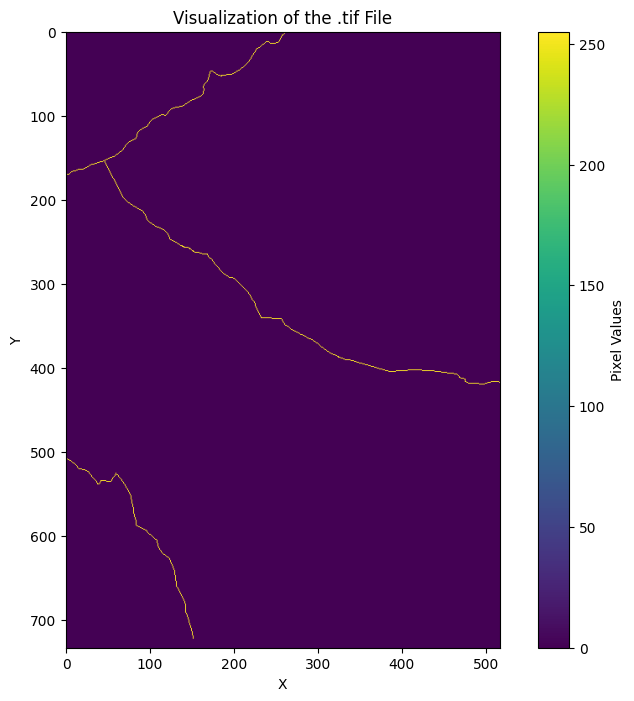

In [62]:
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='viridis')  # Use a colormap like 'viridis'
plt.colorbar(label="Pixel Values")
plt.title("Visualization of the .tif File")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [5]:
import os
import sys
import numpy as np
from osgeo import gdal, osr

def get_valid_data_extent(filepath):
    """
    Open a raster, read its first band, and compute the georeferenced bounding box of
    valid (non-nodata) pixels.
    
    Returns (xmin, ymin, xmax, ymax) in the file's coordinate system.
    """
    ds = gdal.Open(filepath)
    if ds is None:
        print(f"Failed to open {filepath}")
        return None
    band = ds.GetRasterBand(1)
    nodata = band.GetNoDataValue()
    arr = band.ReadAsArray()
    
    # If no nodata value is defined, assume every pixel is valid.
    if nodata is None:
        mask = np.full(arr.shape, True, dtype=bool)
    else:
        mask = (arr != nodata)
    
    # If there are no valid pixels, return None.
    if not np.any(mask):
        ds = None
        return None
    
    # Find row and column indices of valid pixels.
    valid_rows, valid_cols = np.where(mask)
    row_min = int(valid_rows.min())
    row_max = int(valid_rows.max())
    col_min = int(valid_cols.min())
    col_max = int(valid_cols.max())
    
    # Get the geotransform to map pixel coordinates onto geospatial coordinates.
    gt = ds.GetGeoTransform()
    ds = None

    # Compute coordinates:
    # For pixel (col, row), coordinate = (gt[0] + col*gt[1] + row*gt[2], gt[3] + col*gt[4] + row*gt[5])
    # Compute corners of the valid window:
    ul_x = gt[0] + col_min * gt[1] + row_min * gt[2]
    ul_y = gt[3] + col_min * gt[4] + row_min * gt[5]
    lr_x = gt[0] + col_max * gt[1] + row_max * gt[2]
    lr_y = gt[3] + col_max * gt[4] + row_max * gt[5]

    xmin = np.array([ul_x, lr_x], dtype=np.float64).min()
    xmax = np.array([ul_x, lr_x], dtype=np.float64).max()
    ymin = np.array([ul_y, lr_y], dtype=np.float64).min()
    ymax = np.array([ul_y, lr_y], dtype=np.float64).max()
    
    return (xmin, ymin, xmax, ymax)

In [6]:
get_valid_data_extent("Datasets_Hackathon/Climate_Precipitation_Data/2010R.tif")

(np.float64(-12.849997509270906),
 np.float64(15.19999948143959),
 np.float64(-10.649997476488352),
 np.float64(18.29999952763319))

In [7]:


def gather_raster_files(root_dir):
    valid_extensions = ['.tif', '.tiff', '.png']
    files = []
    for dirpath, _, filenames in os.walk(root_dir):
        for f in filenames:
            ext = os.path.splitext(f)[1].lower()
            if ext in valid_extensions:
                files.append(os.path.join(dirpath, f))
    return files

def compute_global_valid_extent(file_list, target_srs="EPSG:4326"):
    """
    For each raster file, compute its valid data extent (transformed into the target SRS),
    and then compute the union of these extents.
    """
    srs_target = osr.SpatialReference()
    srs_target.ImportFromEPSG(int(target_srs.split(':')[1]))
    
    global_xmin = float('inf')
    global_ymin = float('inf')
    global_xmax = -float('inf')
    global_ymax = -float('inf')
    
    for filepath in file_list:
        valid_extent = get_valid_data_extent(filepath)
        if valid_extent is None:
            continue
        # Convert the valid extent from the source SRS to the target SRS.
        ds = gdal.Open(filepath)
        proj = ds.GetProjection()
        srs_source = osr.SpatialReference()
        if proj and proj.strip():
            srs_source.ImportFromWkt(proj)
        else:
            srs_source.ImportFromEPSG(int(target_srs.split(':')[1]))
        transform = osr.CoordinateTransformation(srs_source, srs_target)
        xmin, ymin, xmax, ymax = valid_extent
        
        # Transform the four corners.
        corners = [
            transform.TransformPoint(xmin, ymin),
            transform.TransformPoint(xmin, ymax),
            transform.TransformPoint(xmax, ymin),
            transform.TransformPoint(xmax, ymax)
        ]
        xs = [pt[0] for pt in corners]
        ys = [pt[1] for pt in corners]
        
        global_xmin = np.array([global_xmin, np.array(xs, dtype=np.float64).min()], dtype=np.float64).min()
        global_ymin = np.array([global_ymin, np.array(ys, dtype=np.float64).min()], dtype=np.float64).min()
        global_xmax = np.array([global_xmax, np.array(xs, dtype=np.float64).max()], dtype=np.float64).max()
        global_ymax = np.array([global_ymax, np.array(ys, dtype=np.float64).max()], dtype=np.float64).max()
        ds = None
    
    return (global_xmin, global_ymin, global_xmax, global_ymax)

def process_raster(input_filepath, output_filepath, global_bounds, target_resolution, target_srs):
    """
    Warp a single raster file to the common grid defined by the global_bounds,
    target_resolution, and target_srs.
    """
    (global_xmin, global_ymin, global_xmax, global_ymax) = global_bounds

    # Optionally, determine resampling method based on source resolution.
    ds = gdal.Open(input_filepath)
    gt = ds.GetGeoTransform()
    source_pixel = abs(gt[1])  # assuming square pixels and no rotation
    ds = None
    # Here, if the source pixel is coarser than our target, we average; otherwise, bilinear.
    resample_alg = "average" if source_pixel > target_resolution * 1.01 else "bilinear"
    
    warp_options = gdal.WarpOptions(
        format="GTiff",
        dstSRS=target_srs,
        outputBounds=(global_xmin, global_ymin, global_xmax, global_ymax),
        xRes=target_resolution,
        yRes=target_resolution,
        resampleAlg=resample_alg,
        dstNodata=0
    )
    
    print(f"Processing: {input_filepath}")
    print(f"  -> Output: {output_filepath}")
    print(f"  Resampling method: {resample_alg}")
    result = gdal.Warp(output_filepath, input_filepath, options=warp_options)
    if result is None:
        print(f"Error processing {input_filepath}")
    else:
        result = None
        print(f"Saved normalized raster to {output_filepath}\n")

In [8]:
compute_global_valid_extent(gather_raster_files("Datasets_Hackathon/Climate_Precipitation_Data"))

(np.float64(-12.849997509270906),
 np.float64(15.19999948143959),
 np.float64(-10.649997476488352),
 np.float64(18.29999952763319))

In [18]:
if __name__ == "__main__":
    """
    if len(sys.argv) < 3:
        print("Usage: python normalize_rasters.py <input_root_directory> <output_root_directory> [target_srs]")
        sys.exit(1)
    
    input_root = sys.argv[1]
    output_root = sys.argv[2]
    target_srs = sys.argv[3] if len(sys.argv) >= 4 else "EPSG:4326""
    """

    input_root = r"Datasets_Hackathon/Climate_Precipitation_Data"
    output_root = r"Transformed"
    target_srs = "EPSG:4326"
    
    # Gather files
    files = gather_raster_files(input_root)
    print(f"Found {len(files)} raster files.")
    
    # Compute union of valid data extents (instead of full extents)
    global_bounds = compute_global_valid_extent(files, target_srs)
    if any(b == float('inf') or b == -float('inf') for b in global_bounds):
        print("Could not compute valid global extent correctly. Exiting.")
        sys.exit(1)
    
    print("Global valid (data) extent in target SRS:")
    print(f"  xmin: {global_bounds[0]}, ymin: {global_bounds[1]}, xmax: {global_bounds[2]}, ymax: {global_bounds[3]}")
    
    # Determine target resolution.
    # Here we choose the smallest target resolution found among files.
    # (For simplicity, we just use the smallest pixel of the files—but you might want to compute that per file.)
    target_resolution = float('inf')
    for f in files:
        ds = gdal.Open(f)
        gt = ds.GetGeoTransform()
        pixel_size = abs(gt[1])
        target_resolution = np.array([target_resolution, pixel_size], dtype=np.float64).min()
        ds = None
    print(f"Chosen target resolution: {target_resolution}\n")
    
    # Process (warp) each raster using the computed valid union extent.
    for f in files:
        rel_path = os.path.relpath(f, input_root)
        base, _ = os.path.splitext(rel_path)
        out_file = os.path.join(output_root, base + "_norm.tif")
        os.makedirs(os.path.dirname(out_file), exist_ok=True)
        process_raster(f, out_file, global_bounds, target_resolution, target_srs)


Found 14 raster files.
Global valid (data) extent in target SRS:
  xmin: -12.849997509270906, ymin: 15.19999948143959, xmax: -10.649997476488352, ymax: 18.29999952763319
Chosen target resolution: 0.05000000074505806

Processing: Datasets_Hackathon/Climate_Precipitation_Data/2014R.tif
  -> Output: Transformed/2014R_norm.tif
  Resampling method: bilinear
Saved normalized raster to Transformed/2014R_norm.tif

Processing: Datasets_Hackathon/Climate_Precipitation_Data/2011R.tif
  -> Output: Transformed/2011R_norm.tif
  Resampling method: bilinear
Saved normalized raster to Transformed/2011R_norm.tif

Processing: Datasets_Hackathon/Climate_Precipitation_Data/2012R.tif
  -> Output: Transformed/2012R_norm.tif
  Resampling method: bilinear
Saved normalized raster to Transformed/2012R_norm.tif

Processing: Datasets_Hackathon/Climate_Precipitation_Data/2023R.tif
  -> Output: Transformed/2023R_norm.tif
  Resampling method: bilinear
Saved normalized raster to Transformed/2023R_norm.tif

Processing: